In [1]:
import numpy as np
import pandas as pd
import os
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Enhanced configuration
config = {
    'image_size': (1024, 1024),
    'batch_size': 16,
    'num_augmentations': 10,
    'feature_layers': ['layer2', 'layer3', 'layer4'],
    'ocsvm_params': {
        'kernel': ['rbf', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'nu': [0.01, 0.05, 0.1, 0.2]
    },
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

# Mount Google Drive (Colab specific)
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Colab\ Notebooks/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


Extracting training features...


100%|██████████| 170/170 [05:26<00:00,  1.92s/it]


Extracting test features...


100%|██████████| 6/6 [00:10<00:00,  1.81s/it]

Optimizing OCSVM parameters...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


Best parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
Best validation mAP: nan
Training final model...


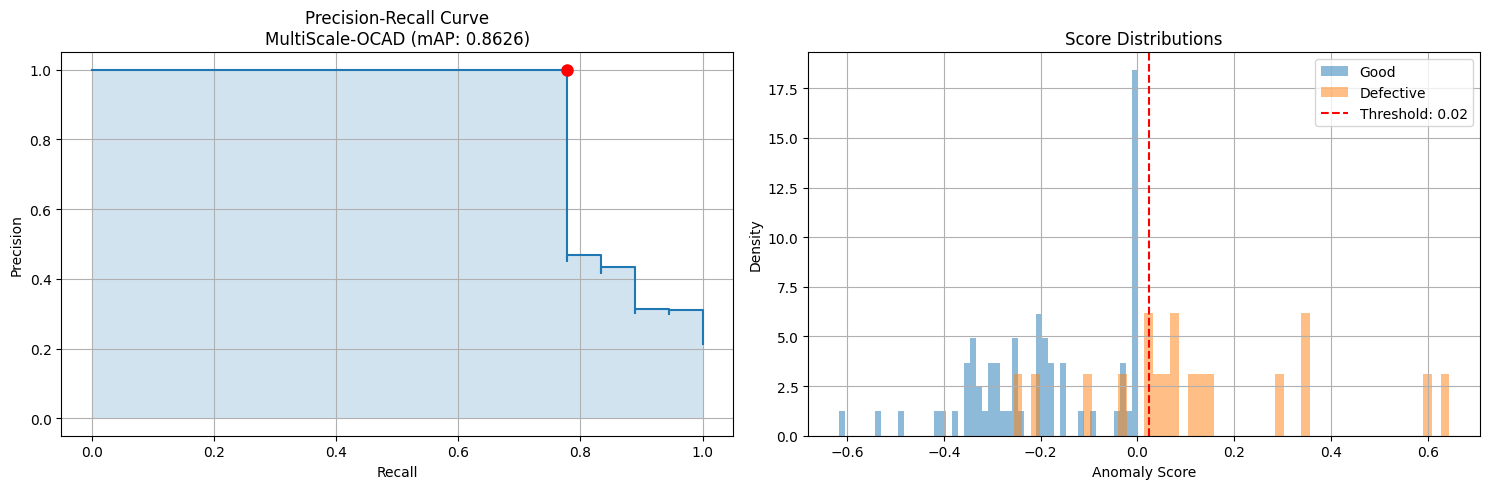


Model: MultiScale-OCAD
mAP: 0.8626
AUROC: 0.9032
Optimal Threshold: 0.0238

Classification Report:
              precision    recall  f1-score   support

        Good       0.94      1.00      0.97        66
   Defective       1.00      0.78      0.88        18

    accuracy                           0.95        84
   macro avg       0.97      0.89      0.92        84
weighted avg       0.96      0.95      0.95        84

Model saved to enhanced_anomaly_detector.pkl


In [2]:
# Load dataset
bad_dir = sorted(glob.glob('/content/drive/MyDrive/anomaly_data/bad/*'))
good_dir = sorted(glob.glob('/content/drive/MyDrive/anomaly_data/good/*'))

# Enhanced transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize(config['image_size']),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(config['image_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class AugmentedDataset(Dataset):
    """Dataset with augmented good samples"""
    def __init__(self, good_files, bad_files, transform=None, num_augmentations=5):
        self.good_files = good_files
        self.bad_files = bad_files
        self.transform = transform
        self.num_augmentations = num_augmentations
        self.all_files = good_files + bad_files
        self.labels = [0] * len(good_files) + [1] * len(bad_files)

    def __len__(self):
        return len(self.good_files) * self.num_augmentations + len(self.bad_files)

    def __getitem__(self, idx):
        if idx < len(self.good_files) * self.num_augmentations:
            # Augmented good sample
            file_idx = idx % len(self.good_files)
            img = Image.open(self.good_files[file_idx]).convert('RGB')
            label = 0
        else:
            # Bad sample (no augmentation)
            bad_idx = idx - len(self.good_files) * self.num_augmentations
            img = Image.open(self.bad_files[bad_idx]).convert('RGB')
            label = 1

        if self.transform:
            img = self.transform(img)
        return img, label

# Split data (80% train, 20% test)
from sklearn.model_selection import train_test_split
train_good, test_good = train_test_split(good_dir, test_size=0.2, random_state=42)
train_bad, test_bad = train_test_split(bad_dir, test_size=0.2, random_state=42)

# Create datasets
train_dataset = AugmentedDataset(
    train_good, train_bad,
    transform=train_transform,
    num_augmentations=config['num_augmentations']
)

test_dataset = AugmentedDataset(
    test_good, test_bad,
    transform=test_transform,
    num_augmentations=1  # No augmentation for test
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=2
)

# Enhanced feature extractor
class MultiLayerFeatureExtractor(nn.Module):
    def __init__(self, backbone='wide_resnet50_2'):
        super().__init__()
        self.backbone = getattr(models, backbone)(pretrained=True)
        self.feature_layers = config['feature_layers']
        self.features = {}
        self.hooks = []

        # Register hooks
        for layer_name in self.feature_layers:
            layer = dict([*self.backbone.named_modules()])[layer_name]
            self.hooks.append(layer.register_forward_hook(self.get_features(layer_name)))

        self.backbone.eval()

    def get_features(self, layer_name):
        def hook(module, input, output):
            self.features[layer_name] = output.detach()
        return hook

    def forward(self, x):
        self.features = {}
        _ = self.backbone(x)
        return [self.features[layer] for layer in self.feature_layers]

    def release(self):
        for hook in self.hooks:
            hook.remove()

# Initialize feature extractor
feature_extractor = MultiLayerFeatureExtractor().to(config['device'])

def extract_features(loader):
    """Extract multi-scale features from images"""
    features = {layer: [] for layer in config['feature_layers']}
    labels = []

    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = images.to(config['device'])
            targets = targets.cpu().numpy()

            # Extract features
            layer_features = feature_extractor(images)

            # Process each layer
            for i, layer in enumerate(config['feature_layers']):
                # Global average pooling
                pooled = nn.AdaptiveAvgPool2d((1, 1))(layer_features[i])
                flattened = pooled.view(pooled.size(0), -1).cpu().numpy()
                features[layer].append(flattened)

            labels.append(targets)

    # Concatenate results
    for layer in config['feature_layers']:
        features[layer] = np.concatenate(features[layer])

    labels = np.concatenate(labels)
    return features, labels

print("Extracting training features...")
train_features, train_labels = extract_features(train_loader)

print("Extracting test features...")
test_features, test_labels = extract_features(test_loader)

# Feature aggregation
def aggregate_features(feature_dict):
    """Aggregate features from multiple layers"""
    aggregated = []
    for layer in config['feature_layers']:
        # Standardize features
        layer_features = feature_dict[layer]
        mean = np.mean(layer_features, axis=0)
        std = np.std(layer_features, axis=0) + 1e-8
        standardized = (layer_features - mean) / std
        aggregated.append(standardized)

    # Concatenate all layer features
    return np.concatenate(aggregated, axis=1)

train_features_agg = aggregate_features(train_features)
test_features_agg = aggregate_features(test_features)

# Separate good and bad features
train_good_features = train_features_agg[train_labels == 0]
train_bad_features = train_features_agg[train_labels == 1]

test_good_features = test_features_agg[test_labels == 0]
test_bad_features = test_features_agg[test_labels == 1]

# Optimize OCSVM parameters
print("Optimizing OCSVM parameters...")
ocsvm = OneClassSVM()
grid_search = GridSearchCV(
    ocsvm,
    config['ocsvm_params'],
    scoring='average_precision',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Train only on good samples
grid_search.fit(train_good_features)

# Get best model
best_ocsvm = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best validation mAP: {grid_search.best_score_:.4f}")

# Train final model on all good samples
print("Training final model...")
all_good_features = np.concatenate([train_good_features, test_good_features])
best_ocsvm.fit(all_good_features)

# Evaluate on test set
def evaluate_model(model, good_features, bad_features, model_name):
    """Evaluate model and plot results"""
    # Calculate scores
    good_scores = -model.decision_function(good_features)  # Higher = more anomalous
    bad_scores = -model.decision_function(bad_features)

    # Combine scores and labels
    y_scores = np.concatenate([good_scores, bad_scores])
    y_true = np.concatenate([np.zeros(len(good_scores)), np.ones(len(bad_scores))])

    # Calculate metrics
    from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)
    auroc = roc_auc_score(y_true, y_scores)

    # Find optimal threshold
    f1_scores = (2 * precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_idx]

    # Apply optimal threshold
    y_pred = (y_scores >= optimal_threshold).astype(int)
    from sklearn.metrics import classification_report
    report = classification_report(y_true, y_pred, target_names=['Good', 'Defective'])

    # Plot results
    plt.figure(figsize=(15, 5))

    # Precision-Recall curve
    plt.subplot(121)
    plt.step(recall, precision, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2)
    plt.plot(recall[best_idx], precision[best_idx], 'ro', markersize=8)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve\n{model_name} (mAP: {avg_precision:.4f})')
    plt.grid(True)

    # Score distributions
    plt.subplot(122)
    plt.hist(good_scores, bins=50, alpha=0.5, label='Good', density=True)
    plt.hist(bad_scores, bins=50, alpha=0.5, label='Defective', density=True)
    plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.title('Score Distributions')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    print(f"mAP: {avg_precision:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print("\nClassification Report:")
    print(report)

    return avg_precision

# Evaluate model
model_name = "MultiScale-OCAD"
final_map = evaluate_model(
    best_ocsvm,
    test_good_features,
    test_bad_features,
    model_name
)

# Save model
import joblib
model_save_path = "enhanced_anomaly_detector.pkl"
joblib.dump(best_ocsvm, model_save_path)
print(f"Model saved to {model_save_path}")

# Feature extractor release
feature_extractor.release()